# Audio Instalations

In [1]:
#!pip install pydub

In [2]:
import glob
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm

from IPython import display as ipd
from PIL import Image

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder,  DatasetFolder,VisionDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import os
import torchvision.models as models

%matplotlib inline
warnings.filterwarnings("ignore")

import torchaudio
#from pydub import AudioSegment
from IPython import display
import random

C:\Users\79671\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\79671\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\79671\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
class CFG:
    JUST_PREDICT  = False
    Kaggle        = False 
    DEBUG         = True
    FULL_DATA     = True
    wandb_on      = False
    seed          = 101
    MULTIMODEL    = False
    weights       = 'imagenet'
    backbone      = 'efficientnet-b1'
    archive_name  = 'Audio'
    models        = []
    optimizers    = []
################################################### 
    num_of_models = 1
    model_number  = 1
    train_bs      = 64
    valid_bs      = 64
    SAMPLE_RATE = 16000
    NUM_SAMPLES = 48000
    number_items   = 1000 if DEBUG else 611829      #8203
    num_test      = 10 if DEBUG else 301      # 1000
    print_every   = 1  if DEBUG else 50      #500
    epochs        = 3  if DEBUG else 22        #35
    ###############################################
    crop_koef     = 1
    lr            = 0.002
    num_workers   = 4 if Kaggle else 0
    criterion     = nn.CrossEntropyLoss()
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 2
    classes       = [0,1]
    activation    = None #'softmax'
    device        = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    
    test_path     = "../input/russian-railways-2/test/test/" if Kaggle else "E:/Audio/ASV/clips/"
    save_path     = '../working/result/' if Kaggle else "./result/"
    train_path    = "E:/Audio/ASV/clips/"
    csv_path      = 'E:/Audio/ASV/valid'
    best_model_w  = '../input/russian-railways-2/best_epoch_ofu-efficientnet-b4_v2.bin' if Kaggle else f'./best_epoch_ofu-{backbone}_v2.bin'


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
#waveform, sample_rate = torchaudio.load('./train/000ad36ce0dcbc1032a606312d5e787d.wav')

In [6]:
#display.Audio(waveform, rate = sample_rate)

In [7]:
#waveform.size()[0]

In [8]:
#Mel_Spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)

In [9]:
#Mel_Spectrogram.shape

In [10]:
#!pip install PySoundFile

In [11]:
# Different classes dataset. 
classes = ('0','1')

In [12]:

data = pd.read_csv(CFG.csv_path, sep = '\t' ) #pd.read_csv(CFG.csv_path, sep = '\\t', header=None)

In [13]:
#data = data.rename(columns={0: "Name", 1: "Target"})

In [14]:
#data = pd.concat([data['path'] , data['fake']] , axis = 1)

In [15]:
#data = data.dropna()

In [16]:
data.head(50)

,path,fake
0,DF_E_2000011,1
1,DF_E_2000013,1
2,DF_E_2000024,1
3,DF_E_2000026,1
4,DF_E_2000027,1
5,DF_E_2000028,1
6,DF_E_2000031,1
7,DF_E_2000032,1
8,DF_E_2000040,1
9,DF_E_2000042,1


In [17]:
data.columns

Index(['path', 'fake'], dtype='object')

In [18]:
 data.shape

(611829, 2)

In [19]:
sum(data['fake'].isnull())

0

In [20]:
#from torchaudio.io import StreamReader
from IPython import display

In [21]:
# audio_ids = list(data[1])
# audio_names = list(data[0])
# print(audio_ids)

In [22]:
class UrbanSoundDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                lable = False):
        self.annotations = annotations_file
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.lable = lable

    def __len__(self):
        return len(self.audio_dir)

    def __getitem__(self, index):
        #print(index)
        audio_sample_path = self._get_audio_sample_path(index)
        signal, sr = torchaudio.load(audio_sample_path)
        #signal = self._resample_if_necessary(signal, sr)
        #signal = self._cut_if_necessary(signal)
        #signal = self._right_pad_if_necessary(signal)
        #signal = signal.repeat(3, 1, 1)
        #signal = torch.squeeze(signal)
        #signal = self.transformation(signal)
        if self.lable == True: # WHEN WE TRAIN
            label = self._get_audio_sample_label(index)
            return signal, label
        else: # WHEN WE PREDICT
            return signal, torch.randint(0, 1, (1,))

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, : self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = self.audio_dir[index]
        if self.lable == True:
            path = os.path.join(CFG.train_path,path)
        else:
            path = os.path.join(CFG.test_path,path)
        path = path + '.flac'
        return path

    def _get_audio_sample_label(self, index):
        path = self.audio_dir[index]
        #print(path)
        df = self.annotations
        df = df.loc[lambda df: df['path'] == path]
        #print(df.head())
        num = list(df['fake'])
        #print(num)
        return torch.Tensor(num)


# if __name__ == "__main__":
#     ANNOTATIONS_FILE = "/home/valerio/datasets/UrbanSound8K/metadata/UrbanSound8K.csv"
#     AUDIO_DIR = "/home/valerio/datasets/UrbanSound8K/audio"
#     SAMPLE_RATE = 22050
#     NUM_SAMPLES = 22050

#     mel_spectrogram = torchaudio.transforms.MelSpectrogram(
#         sample_rate=SAMPLE_RATE,
#         n_fft=1024,
#         hop_length=512,
#         n_mels=64
#     )

#     usd = UrbanSoundDataset(ANNOTATIONS_FILE,
#                             AUDIO_DIR,
#                             mel_spectrogram,
#                             SAMPLE_RATE,
#                             NUM_SAMPLES)
#     print(f"There are {len(usd)} samples in the dataset.")
#     signal, label = usd[1]

In [23]:
# def clearing_names(audio_names : list, data) :
#     for audio in enumerate(audio_names):
#         if audio not in data:
#             audio_names.remove(audio)
#     return audio_names, data

In [24]:
# audio_names= [os.path.join(CFG.train_path,item_name) for item_name in os.listdir(CFG.train_path)]

In [25]:
# audio_names


In [26]:
# good_names = []
# bad_names = []
# good_names = [try for item_name in audio_names]
# for ind, name in enumerate(audio_names):

In [27]:
# good_names = []
# bad_names = []
# for ind, name in enumerate(audio_names):
#     try:
#         torchaudio.load(name)
#         good_names.append(name)
#         print(ind)
#     except Exception:
#         bad_names.append(name)

In [28]:
# len(good_names) , len(bad_names)

In [29]:
# gn = good_names

In [30]:
# gn = [item_name.split('s/')[1] for item_name in gn ]

In [31]:
# gn = [item_name.split('.')[0] for item_name in gn ]

In [32]:
# df = pd.DataFrame({'Names':gn})

In [33]:
# df.head()

In [34]:
# audio_names = pd.read_csv('./good_names',header=None, index_col=False)

In [35]:
# audio_names = list(audio_names[0])

In [36]:
# audio_names

In [37]:
# lol

In [38]:
# df.to_csv('good_names', index=False,header = False )

In [39]:
def prepare_loaders():
    audio_names = pd.read_csv(CFG.csv_path, sep = '\t' )
    audio_names = list(audio_names['path'])
    #audio_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.train_path)] #[os.path.join("./train/",item_name)  for item_name in os.listdir(CFG.train_path)]
    random.shuffle(audio_names)
    audio_names = audio_names[:CFG.number_items]
    print(len(audio_names))
    audio_train_valid, audio_test = train_test_split(audio_names, test_size=0.2 , random_state=42)
    audio_train, audio_valid = train_test_split(audio_train_valid, test_size=0.25 , random_state=42)
    #print(type(train_ids))
    #print(valid_ids)
    train_dataset = UrbanSoundDataset(data, audio_train, mel_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, True)
    valid_dataset = UrbanSoundDataset(data, audio_valid, mel_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, True)
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=True,collate_fn=Collator(), drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False,collate_fn=Collator(), pin_memory=True)
    
    return train_loader, valid_loader

## Audio Augmentations

In [40]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=CFG.SAMPLE_RATE,
    n_fft=1024,
    win_length = 1024,
    hop_length=256,
    n_mels=80,
    window_fn = torch.hann_window,
    center=True
)



     

## Fit EfficientNet

In [41]:
def Melspectrogram_visualize(array: torch.Tensor):
    #print(array.shape)
    plt.figure(figsize=(20, 5))
    plt.imshow(array.squeeze().log())
    plt.xlabel('Time', size=20)
    plt.ylabel('Frequency (Hz)', size=20)
    plt.show()

    
    
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

In [42]:
from typing import List , Tuple

In [43]:
class Collator:
    def __call__(self, batch: List[Tuple[torch.Tensor, int]]):
        lengths = []
        wavs, labels = zip(*batch)
        
        for wav in wavs:
            lengths.append(wav.size(-1))
        
        # here we should pad wvas to one length, cause we need pass it to network
        batch_wavs = torch.zeros(len(batch), max(lengths))
        for i, wav in enumerate(wavs):
            batch_wavs[i, :lengths[i]]=wav
            
        
        
        labels = torch.tensor(labels).long()
        lengths = torch.tensor(lengths).long()
        
        return {
            'wav': batch_wavs,
            'label': labels,
            'length': lengths,
        }

In [44]:
train_loader, valid_loader = prepare_loaders()

1000


In [45]:
len(train_loader) , len(valid_loader)

(10, 4)

In [46]:
audio = next(iter(train_loader))
#print(audio['wav'].shape)
#print(Class)
audio['wav'].shape

torch.Size([64, 108544])

In [47]:
#Melspectrogram_visualize(audio)

In [48]:

class Featurizer(nn.Module):
    
    def __init__(self):
        super(Featurizer, self).__init__()
        
        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=16_000,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            n_mels=64,
            center=True
        )
        
    def forward(self, wav, length=None):
        mel_spectrogram = self.featurizer(wav)
        mel_spectrogram = mel_spectrogram.clamp(min=1e-5).log()
        
        if length is not None:
            length = (length - self.featurizer.win_length) // self.featurizer.hop_length
            # We add `4` because in MelSpectrogram center==True
            length += 1 + 4
            
            return mel_spectrogram, length
        
        return mel_spectrogram

In [49]:
class Model(nn.Module):
    
    def __init__(self, input_dim, hidden_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        
        self.rnn = nn.LSTM(input_size=input_dim,
                           hidden_size=hidden_size,
                           num_layers = 1,
                           batch_first=True,
                           bidirectional = False)
        self.clf = nn.Linear(hidden_size, 2)
    
    def forward(self, input, length=None):
        # input: (batch_size, hidden_size, seq_len)
        output, _ = self.rnn(input.transpose(-1, -2))
        # output: (batch_size, seq_len, hidden_size)
        
        # Now we want to take the last hidden state of each instance in batch
        # BUT we don't want to take `padding` hidden state
        # We will use `torch.gather` and `length` to dio that
        
        # learn more about gather
        # https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4
        
        last_hidden = torch.gather(
            output,
            dim =1,
            index = length.sub(1).view(-1, 1, 1).expand(-1, -1, self.hidden_size)
        )
        
        logits = self.clf(last_hidden.squeeze(dim=1))
        
        return logits

In [50]:
device = CFG.device

model = Model(input_dim=64, hidden_size=128).to(device)
featurizer = Featurizer().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [51]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [52]:
from collections import defaultdict

In [53]:
storage = defaultdict(list)

In [68]:
def compute_det_curve(target_scores, nontarget_scores):

    n_scores = target_scores.size + nontarget_scores.size
    all_scores = np.concatenate((target_scores, nontarget_scores))
    labels = np.concatenate((np.ones(target_scores.size), np.zeros(nontarget_scores.size)))

    # Sort labels based on scores
    indices = np.argsort(all_scores, kind='mergesort')
    labels = labels[indices]

    # Compute false rejection and false acceptance rates
    tar_trial_sums = np.cumsum(labels)
    nontarget_trial_sums = nontarget_scores.size - (np.arange(1, n_scores + 1) - tar_trial_sums)

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums / target_scores.size))  # false rejection rates
    far = np.concatenate((np.atleast_1d(1), nontarget_trial_sums / nontarget_scores.size))  # false acceptance rates
    thresholds = np.concatenate((np.atleast_1d(all_scores[indices[0]] - 0.001), all_scores[indices]))  # Thresholds are the sorted scores

    return frr, far, thresholds
def compute_eer(target_scores, nontarget_scores):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

F1 :0.9841269841269841 , EER: (1.0, 1.0)
F1 :0.959349593495935 , EER: (1.0, 1.0)
F1 :1.0 , EER: (1.0, 1.0)
F1 :0.9333333333333333 , EER: (1.0, 1.0)


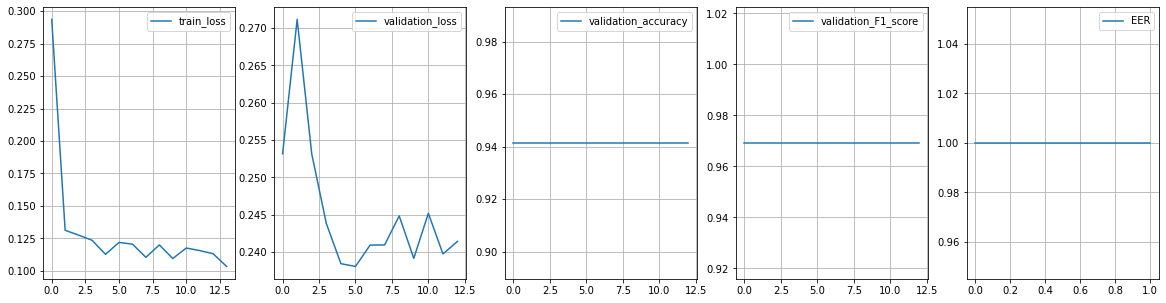

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

F1 :0.9841269841269841 , EER: (1.0, 1.0)
F1 :0.959349593495935 , EER: (1.0, 1.0)
F1 :1.0 , EER: (1.0, 1.0)
F1 :0.9333333333333333 , EER: (1.0, 1.0)


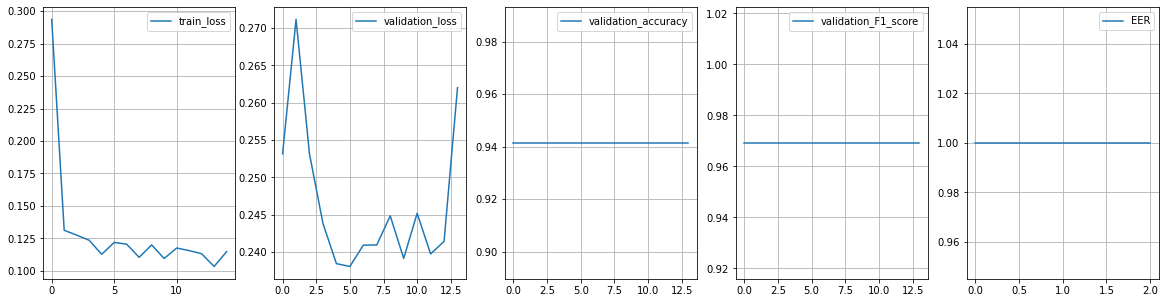

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

F1 :0.9841269841269841 , EER: (1.0, 1.0)
F1 :0.959349593495935 , EER: (1.0, 1.0)
F1 :1.0 , EER: (1.0, 1.0)
F1 :0.9333333333333333 , EER: (1.0, 1.0)


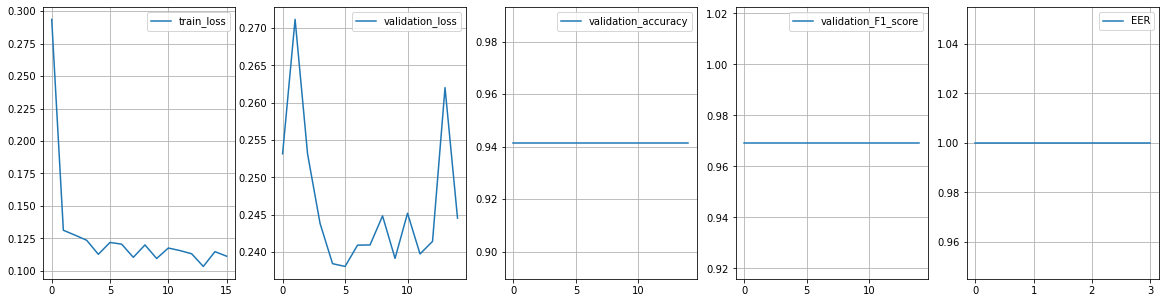

In [152]:
for epoch in range(CFG.epochs):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        mel, mel_length = featurizer(wav, length)
        output = model(mel, mel_length)
        #print(f'output :{output.argmax(dim=-1)}')
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
###################################################################################################################
#############################################  Validation  ########################################################
###################################################################################################################

    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()
    validation_f1_meter = AverageMeter()
    validation_EER_meter = AverageMeter()
    model.eval()
    for i, batch in enumerate(tqdm(valid_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)

            loss = criterion(output, label)
            out = output.argmax(dim=-1).cpu().numpy()
            labels = label.cpu().numpy()
        #print(f'output :{output.argmax(dim=-1)}, label : {label}')
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
        f1 = f1_score(output.argmax(dim=-1).cpu(), label.cpu(), average= 'weighted')
        eer = compute_eer(labels,out)
        validation_EER_meter.update(eer[0])
        validation_f1_meter.update(f1)
        print(f'F1 :{f1} , EER: {eer}')
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    storage['validation_F1_score'].append(validation_f1_meter.avg)
    storage['validation_EER'].append(validation_EER_meter.avg)
    #display.clear_output()
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')
    
    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')
    axes[3].plot(storage['validation_F1_score'], label='validation_F1_score')
    axes[4].plot(storage['validation_EER'], label='EER')
    for i in range(5):
        axes[i].grid()
        axes[i].legend()

    plt.show()


In [144]:
out = output.argmax(dim=-1).cpu().numpy()

In [99]:
np.array?

In [145]:
#labels = np.array([0,1,0,1])
#out = np.array([1,1,0,0])
print(label)
print(out)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


In [150]:
eer = compute_eer(labels,out)
print(eer[0])

1.0


In [55]:
storage['validation_F1_score']
    

[0.9692024777390631, 0.9692024777390631, 0.9692024777390631]

In [56]:
f1_score(out.cpu(),label.cpu(),average='weighted')

0.9333333333333333

In [57]:
#fit(model, CFG.epochs , train_loader, valid_loader, optimizer, CFG.criterion, CFG.device)

## Efficcient_net predict

In [58]:
#test = []
'./test/'
items_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.test_path)]#os.path.join("./test",item_name)
test_dataset = UrbanSoundDataset(data, items_names, mel_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False, pin_memory=True, drop_last=False,collate_fn=Collator())


In [59]:
test = []
for i, batch in enumerate(tqdm(test_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)
            #print(output)
            _, pred = torch.max(output, 1) # Return values and indices
            #m = nn.Softmax(dim=1)
            #pred = m(output)
            #print(pred)
            #print(pred.item())
            #df
            test.append(classes[pred.item()])
#print(test)

  0%|          | 0/611829 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(len(test))

In [ ]:
items_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.test_path)]

In [ ]:
df = pd.DataFrame({"id" :items_names,
                   "eff": test
        
                  })

In [ ]:
df.head(2)

In [ ]:

ansamble_pred = df['eff'].to_numpy()

In [ ]:
#df.to_csv?

In [ ]:
print('Generating submission file...')
#os.chdir("./")
df.to_csv('answers.tsv',index=False, sep = '\t',header = False)

In [ ]:
# df = pd.DataFrame({"id" : range(1,250),
#                    "class": ansamble_pred
# #                   }

In [ ]:
# df = pd.DataFrame({"id" : range(1,250),
#                    "class": test
#                   })

In [ ]:
# df["class"]

In [ ]:
# df.tail(50)

In [ ]:
# df_full.tail(50)

In [ ]:
# print('Generating submission file...')
#os.chdir("./")
# df.to_csv('submission_audio.csv',index=False)

In [ ]:
# df_full.to_csv('submission_effnet7new2.csv',index=False)